In [1]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)

from pettingzoo.classic import tictactoe_v3
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.dqn_agent import DQNAgent
from source.agents.random_agent import RandomAgent
from source import utils
from tqdm import tqdm
import torch
import random
from typing import Dict, Optional, Tuple
from collections import defaultdict
from source.agents.agent import Agent
from pettingzoo.utils.env import AECEnv

/Users/tonywy/micromamba/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device: cpu
dqn_agent test passed!


In [2]:
def play_episode(agent_dict: Dict[str, Agent], env: AECEnv) -> Tuple[defaultdict, defaultdict]:
    env.reset()
    for agent in agent_dict.values():
        agent.reset()
    steps, total_reward= defaultdict(int), defaultdict(float)
    history = defaultdict(list)

    for agent_id in env.agent_iter():
        agent = agent_dict[agent_id]
        # Make observation
        observation, reward, terminal, truncated, info = env.last()
        if observation is None:
            continue 
        ob_tensor = utils.to_feature(observation['observation'])
        mask_tensor = torch.tensor(observation['action_mask'])
        # Select action
        if terminal or truncated:
            action = None
        else:
            action = agent.sample_action(ob_tensor, mask_tensor)
        env.step(None if action is None else action.item())
        # Train the agent
        if agent._learning and agent_id in history:
            prev_ob, prev_action = history[agent_id][-1]
            agent.control(prev_ob, prev_action, reward, ob_tensor,
                            terminal)
        history[agent_id].append((ob_tensor, action))
        # bookkeeping
        total_reward[agent_id] += reward 
        steps[agent_id] += 1
        #if steps > 1000:
        #    terminal = True
    return total_reward, steps

In [3]:
def evaluate_agent(agent_dict: Dict[str, Agent], env: AECEnv, num_episode: int = 100000, epsilon: float = 0.0, threshold: float = 0.0):
    for agent in agent_dict.values():
        agent._epsilon = 0.0
    total_reward = defaultdict(float)
    successful_episode = 0
    for _ in tqdm(range(num_episode)):
        rewards, steps = play_episode(agent_dict, env)#,epsilon=epsilon_schedule[i])
        for agent, reward in rewards.items():
            total_reward[agent] += reward 
    return total_reward, num_episode

using device: cpu


100%|██████████| 1000/1000 [00:05<00:00, 185.11it/s]


step: 0, epsilon: 0.2808041886388177, average_return: 0.502, success rate: 0.0


100%|██████████| 1000/1000 [00:04<00:00, 202.46it/s]


step: 1, epsilon: 0.12103952053848177, average_return: 0.634, success rate: 0.0


100%|██████████| 1000/1000 [00:04<00:00, 205.85it/s]


step: 2, epsilon: 0.07282606343399001, average_return: 0.7213333333333334, success rate: 0.0


100%|██████████| 1000/1000 [00:04<00:00, 204.51it/s]


step: 3, epsilon: 0.05718912654775774, average_return: 0.762, success rate: 0.0


100%|██████████| 1000/1000 [00:04<00:00, 205.03it/s]


step: 4, epsilon: 0.0522083295047054, average_return: 0.7968, success rate: 0.0

rewarding episodes: 3984.0


100%|██████████| 5000/5000 [00:26<00:00, 191.95it/s]


player_1: Average return = 0.8522
player_2: Average return = -0.8522


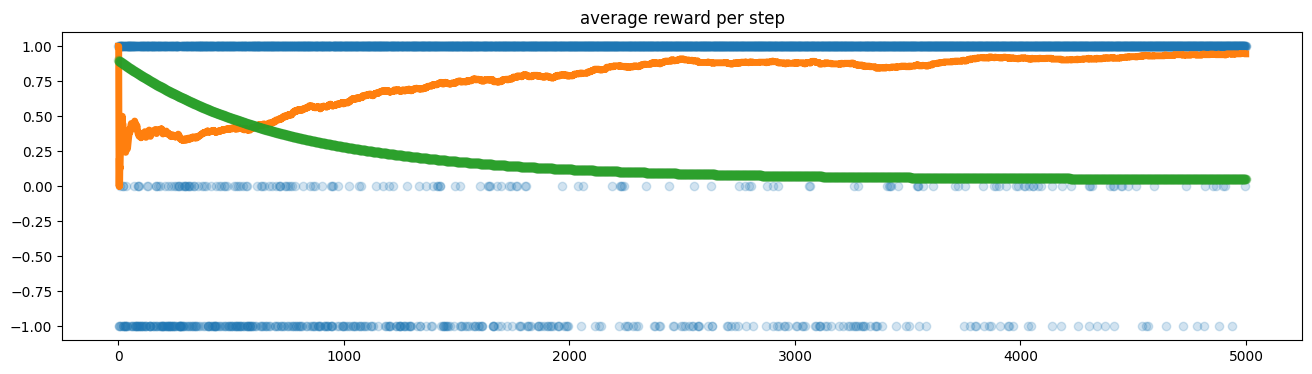

In [10]:
# Policy Eval
# Params
num_epoch = 5
num_episode = 1000
video_path = os.path.join(ROOT, "video/dqn_tictactoe.mp4")
random_seed = 101

# Initialize
history = []
total_reward = 0
# set random seeds
rng = np.random.default_rng(random_seed)
#random.seed(random_seed)
np.random.seed(random_seed)
#torch.manual_seed(random_seed)
# epsilon decay
epsilon_schedule = utils.create_decay_schedule(num_epoch)
lr_schedule = utils.create_decay_schedule(num_epoch)

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
#env = gym.make(
#    "LunarLander-v2",
#    render_mode='rgb_array'
#)
#env = gym.make("CarRacing-v2", render_mode='rgb_array', continuous=False)
#env = gym.make("CartPole-v1", render_mode='rgb_array')

env = tictactoe_v3.env()
env.np_random = rng

# Create Agent
dqn_agent = DQNAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.99,
    epsilon=None, # use epsilon_schedule
    learning_rate=1e-4,
    learning=True,
    batch_size = 8,
    tau = 0.005,
    eps_decay=3000
)
random_agent = RandomAgent(    
    state_space=env.observation_space('player_2')['observation'],
    action_space=env.action_space('player_2'),
    discount_rate=None,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    learning=False
)
agent_dict = {'player_1': dqn_agent, 'player_2':random_agent}
eps_history = []
hisotry = []
# Start Learning
for i in range(num_epoch):
    success = 0
    for _ in tqdm(range(num_episode)):
        reward, steps = play_episode(agent_dict, env)#,epsilon=epsilon_schedule[i])
        history.append(reward['player_1'])
        eps_history.append(agent_dict['player_1']._epsilon)
        total_reward += reward['player_1']
    #score = agent.update()
    print(
        f"step: {i}, epsilon: {dqn_agent._epsilon}, average_return: {np.mean(history)}, success rate: {success / num_episode}")
print(f"\nrewarding episodes: {total_reward}")

# For off policy learning only: get greedy policy (no exploration)
#agent._policy = get_epsilon_greedy_policy_from_action_values(agent._Q.weight)
# Run Eval
avarge_return, num_episode = evaluate_agent(agent_dict, env, 5000)
for ag_id, value in avarge_return.items():
    print(f"{ag_id}: Average return = {value / num_episode}")

utils.plot_history(history)
utils.plot_history(eps_history, smoothing=False)

In [11]:
env = tictactoe_v3.env(render_mode='human')
reward, _ = play_episode(agent_dict, env)
#html=utils.render_mp4(video_path)
#HTML(html)


     |     |     
  X  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  O  |  -  |  -  
     |     |     
     |     |     
  X  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  O  |  -  |  X  
     |     |     
     |     |     
  X  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  O  |  O  |  X  
     |     |     
     |     |     
  X  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  O  |  O  |  X  
     |     |     
     |     |     
  X  |  X  |  O  
_____|_____|_____
     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  O  |  O  |  X  
     |     |     
     |     |     
  X  |  X 